# Clusterisation

## Preprocessing

On s'inspire ici largement de la méthode de clusterisation vue en cours. On commence par importer les modules nécessaires au projet.

In [4]:
import pandas as pd
from _jointure_validations_stations import df_jointure_validations_stations
import matplotlib.pyplot as plt
from _pre_proces_stations import df_stations

In [6]:
data=df_jointure_validations_stations()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [2]:
data.shape

(204317, 74)

Pour mener le processus à bien, nous avons besoin de conserver uniquement les colonnes numériques, et enlver celles qui n'ont pas d'intérêt pour l'analyse (les colonnes d'identification).

In [7]:
import numpy as np 

data_clustering = data.drop(
    ['lda', 'Année', 'Geo Point', 'Geo Shape', 'id_ref_ZdC', 'nom_ZdC', 'id_ref_ZdA', 'gares_id', 'x', 'y', 'idrefliga', 'idrefligc', 'indice_lig'],
    axis=1
).dropna(
    axis=1, how='all' 
).select_dtypes(
    include=np.number
)

data_clustering

,NB_VALD,Mois,lignes,bus_jour,noctilien,idf,principal,index_right,i_est_1km,ind,...,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt,
0,55,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
1,32,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
2,93,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
3,316,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
4,458,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204312,320,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204313,893,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204314,9,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204315,7,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN


On regarde s'il y a des NaN dans notre tableau ; si oui, on les remplace par la valeur de la colonne la plus fréquente.

In [8]:
data_clustering.isna().any().any()

True

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
data_clustering_2 = imputer.fit_transform(data_clustering)


Enfin, on scale nos données pour que la clusterisation soit plus rapide et efficace.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_clustering_3 = scaler.fit_transform(data_clustering_2)


In [11]:
jointure_cluster = np.copy(data_clustering_3)

## K-moyennes

Une fois terminées les étapes de preprocessing, on passe à la clusterisation à proprement parler. On utilisera ici la méthode dite des "K-moyennes". La première étape consiste à choisir le nombre de clusters adéquat, ce qui sera détemriné par la méthode du coude, implémentée sous le nom de "KElbowVisualizer".

In [12]:
!pip install yellowbrick

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, n_init=10),
                 k=(1, 10))

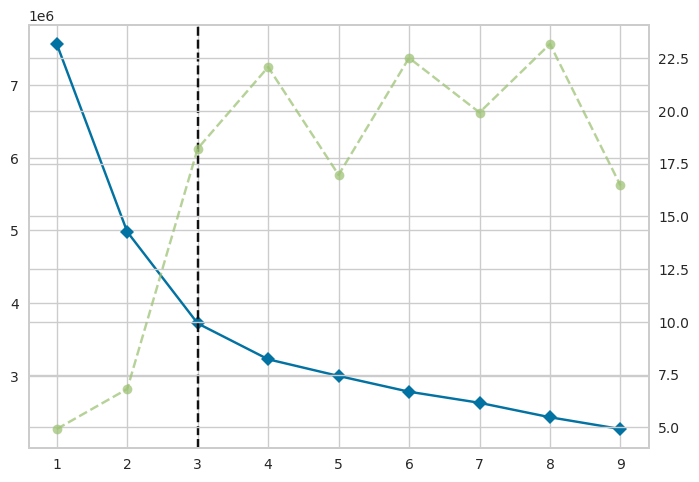

In [13]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

#super()._check_params_vs_input(X, default_n_init=10)
plt.rcParams['font.family'] = 'DejaVu Sans' # Changement de police pour éviter les erreurs en sortie
elbow_method = KElbowVisualizer(KMeans(n_init=10), k=(1,10)) # le  n initial est fixé à 10 pour éviter les erreurs
elbow_method.fit(jointure_cluster)


Le k obtenu se lit au point d'inflexion de la courbe bleue : ici, k=3. On peut alors réaliser les clusters à proprement parler en utilisant cette nouvelle donnée.

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=7, n_init=10)
clusters_kmeans = kmeans.fit_predict(jointure_cluster)


On peut désormais compter le nombre d'éléments dans chacun de nos 3 clusters, en transformant notre sortie clusters_kmeans en un dataframe pour en faciliter le comptage

In [12]:
clusters = pd.DataFrame(clusters_kmeans, columns=['Cluster'])
taille = clusters['Cluster'].value_counts()
taille 

Cluster
1    105783
0     92126
2      6408
Name: count, dtype: int64

Pour visualiser et interpréter les clusters, on passe désormais à l'analyse en composantes principales : on regarde leur poids respectifs dans chacune des composantes principales 1,2 et 3.

In [15]:
from sklearn.decomposition import PCA

acp = PCA(n_components=3)
projection_array = acp.fit_transform(jointure_cluster)
projection = pd.DataFrame(data=projection_array, columns=['PC1', 'PC2', 'PC3'])

# Obtenir les poids des caractéristiques pour chaque composante principale
composantes_principales = pd.DataFrame(acp.components_, columns=data_clustering.columns)


On regarde ensuite quelles sont les 10 caractéristiques principales :

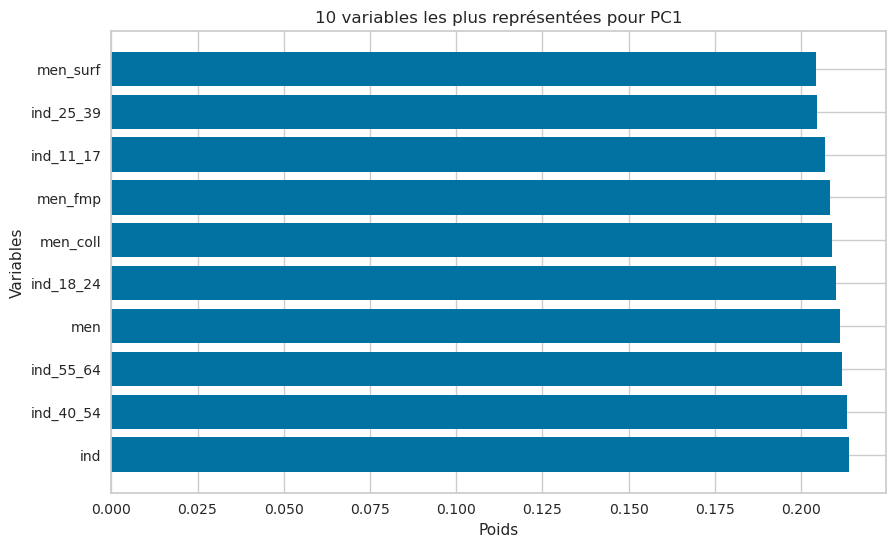

In [17]:
pc1_top_features_abs = composantes_principales.iloc[0].abs().nlargest(10, keep='all')
pc1_top_features = composantes_principales.iloc[0].loc[pc1_top_features_abs.index]

plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title(f'{10} variables les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

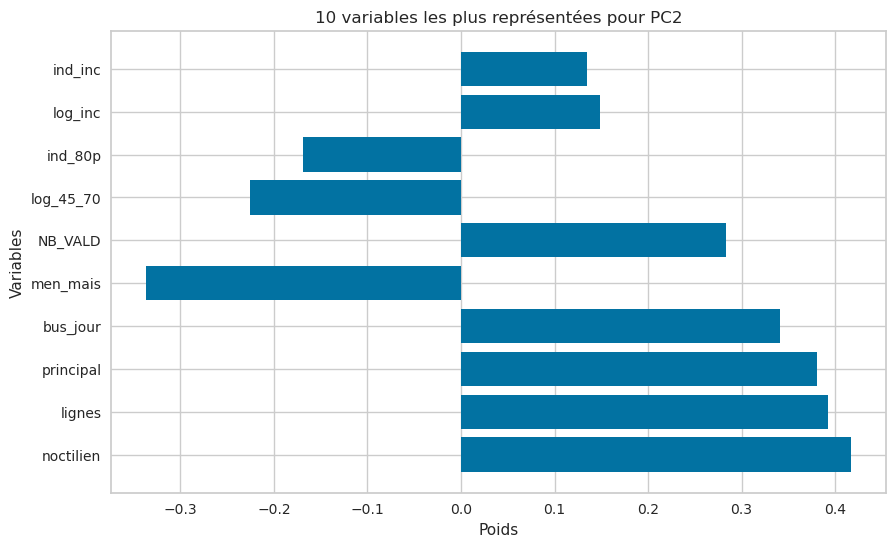

In [18]:
pc2_top_features_abs = composantes_principales.iloc[1].abs().nlargest(10, keep='all')
pc2_top_features = composantes_principales.iloc[1].loc[pc2_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc2_top_features.index, pc2_top_features.values)
plt.title(f'{10} variables les plus représentées pour PC2')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

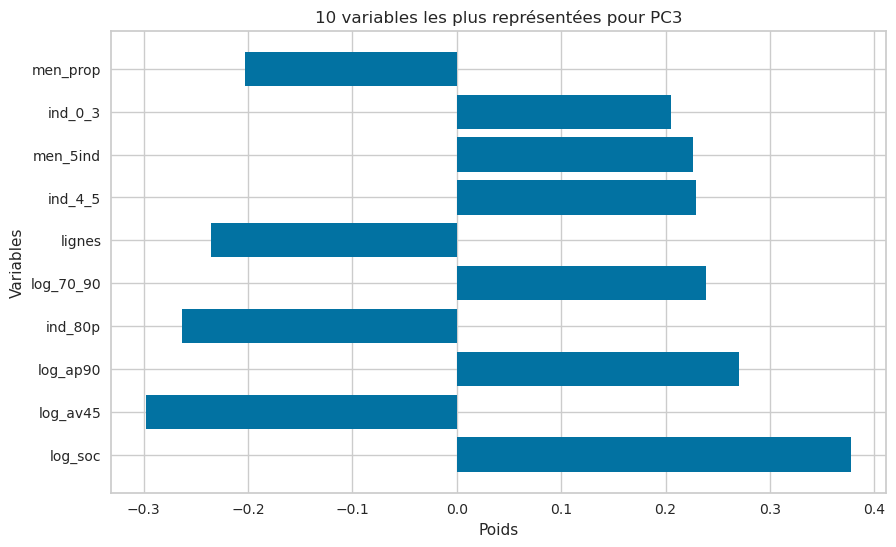

In [19]:
pc3_top_features_abs = composantes_principales.iloc[2].abs().nlargest(10, keep='all')
pc3_top_features = composantes_principales.iloc[2].loc[pc3_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc3_top_features.index, pc3_top_features.values)
plt.title(f'{10} variables les plus représentées pour PC3')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

Une fois ces graphiques donnant la pondération de chaque variable réalisés, on peut visualiser les clusters obtenus :

In [26]:
projection_clusters = projection.copy()
projection_clusters['cluster_kmeans'] = clusters_kmeans

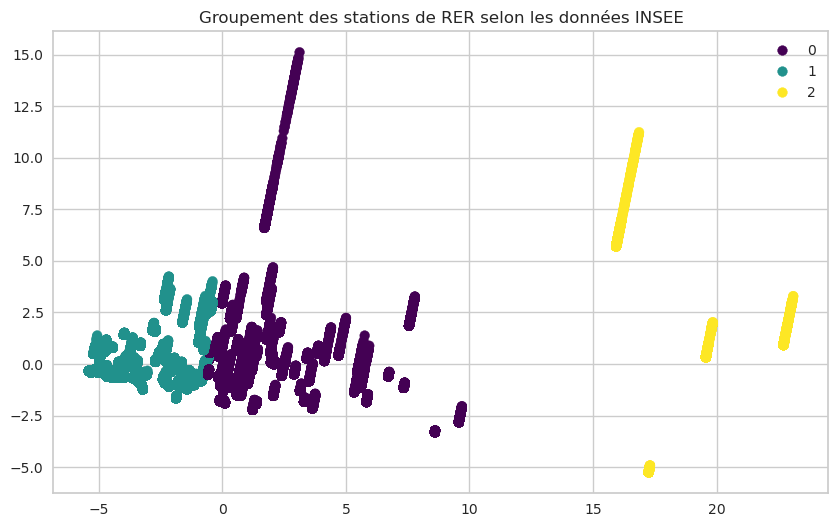

In [27]:
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(
    projection_clusters['PC1'],
    projection_clusters['PC2'],
    c=projection_clusters['cluster_kmeans'],
    cmap='viridis'
)

plt.legend(handles=scatter_plot.legend_elements()[0], labels=range(3))
plt.title('Groupement des stations de RER selon les données INSEE')

plt.show()